# Generate Beam-Related Neutron (BRN)

Basically the old code from here, https://github.com/yuntsebaryon/SimpleCosmics/blob/main/BRN/BRNSpectrum.ipynb, but now filling the data into a hepevt file

In [1]:
import ROOT
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the BRN spectrum

In [2]:
filename = '/Users/yuntse/data/coherent/preLArTPC/mcnp/BRN_400M_100cm_1e5.root'
f = ROOT.TFile( filename, 'READ')

In [3]:
hBRN = f.Get("1")

In [4]:
canvas = ROOT.TCanvas("c1", "BRN KE")
hBRN.Draw()
canvas.Draw()

In [5]:
brn = np.array([ hBRN.GetBinContent(i+1) for i in range(hBRN.GetNbinsX()) ])
brn_bins = np.array([ hBRN.GetBinLowEdge(i+1) for i in range(hBRN.GetNbinsX() + 1) ])

In [6]:
brn

array([19716.,  2688.,  2803.,  1351.,  1160.,   868.,   767.,   552.,
         489.,   445.,   356.,   330.,   275.,   255.,   247.,   271.,
         282.,   257.,   249.,   248.,   203.,   223.,   205.,   220.,
         207.,   215.,   210.,   213.,   210.,   201.,   210.,   223.,
         213.,   215.,   190.,   209.,   199.,   205.,   202.,   192.,
         190.,   193.,   184.,   210.,   205.,   199.,   214.,   210.,
         211.,   211.,   195.,   202.,   193.,   193.,   191.,   194.,
         196.,   205.,   209.,   183.,   224.,   223.,   217.,   237.,
         223.,   233.,   188.,   198.,   199.,   227.,   221.,   214.,
         185.,   212.,   217.,   210.,   204.,   183.,   211.,   212.,
         218.,   191.,   206.,   228.,   205.,   200.,   163.,   194.,
         190.,   186.,   175.,   185.,   190.,   195.,   208.,   186.,
         185.,   177.,   185.,   191.,   199.,   138.,   183.,   170.,
         160.,   184.,   163.,   177.,   183.,   176.,   180.,   169.,
      

In [7]:
brn_bins

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [8]:
brn.sum()-72.-70.-110.-545.-5399.

79369.0

## Generate BRN Kinetic Energy

In [9]:
rng = np.random.default_rng()

In [10]:
def getNSamples(xmin, xmax, N):
    return rng.uniform(xmin, xmax, N)

In [11]:
def isAccepted(n, vPDF, maxPDF):
    return rng.uniform(0., maxPDF, n) < vPDF

In [12]:
def rejectSampling(kemin, kemax, nSamples):
    outSamples = getNSamples(kemin, kemax, nSamples)
    outSampleBins = np.floor(outSamples).astype(int)
    outPDF = brn[outSampleBins]
    maxPDF = brn[0]

    mask = isAccepted(len(outSamples), outPDF, maxPDF)
    reject, = np.where(~mask)

    while reject.size > 0:
        fill = getNSamples(kemin, kemax, reject.size)
        fillBins = np.floor(fill).astype(int)
        
        fillPDF = brn[fillBins]
        mask = isAccepted(len(fill), fillPDF, maxPDF)
        outSamples[reject[mask]] = fill[mask]
        reject = reject[~mask]

    return outSamples

In [13]:
nSamples = 500000
voutSamples = rejectSampling(0., 395., nSamples)
len(voutSamples)

500000

In [14]:
voutSamples

array([330.79703589,   8.39444124, 365.06549877, ...,  21.09724229,
         2.5918773 ,   9.66614435])

## Validation

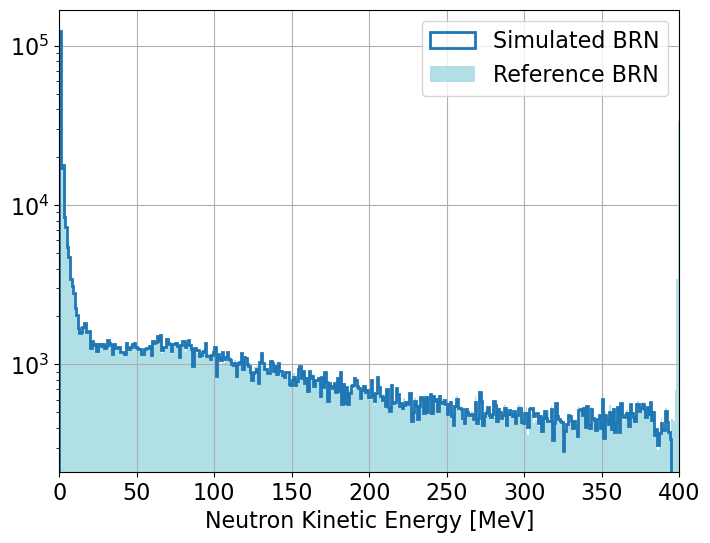

In [15]:
fig, ax = plt.subplots( figsize = (8, 6) )  

ax.hist(voutSamples, bins = np.linspace(0, 400, 401), histtype = 'step', lw = 2, label = 'Simulated BRN')
ax.bar(brn_bins[:-1], brn*nSamples/79369., width = np.diff(brn_bins), align = "edge", 
       color = 'powderblue', label = 'Reference BRN')
ax.set_xlabel( 'Neutron Kinetic Energy [MeV]', fontsize = 16 )
ax.tick_params(axis = 'x', labelsize = 16)
ax.tick_params(axis = 'y', labelsize = 16)
ax.set_xlim( [0, 400])
ax.semilogy()
ax.grid(':')
ax.legend( fontsize = 16)
fig.savefig('BRNSpectrum.pdf')

In [16]:
outHist = np.histogram(voutSamples, bins = np.linspace(0, 395, 396))
outHist

(array([124582,  17066,  17776,   8470,   7260,   5479,   4701,   3458,
          3103,   2819,   2252,   2050,   1691,   1586,   1590,   1720,
          1814,   1590,   1588,   1628,   1262,   1404,   1322,   1342,
          1214,   1336,   1338,   1305,   1338,   1275,   1308,   1421,
          1369,   1333,   1157,   1343,   1276,   1277,   1283,   1197,
          1197,   1203,   1164,   1361,   1259,   1242,   1284,   1340,
          1360,   1291,   1259,   1244,   1249,   1168,   1161,   1245,
          1272,   1263,   1304,   1141,   1408,   1372,   1381,   1507,
          1394,   1525,   1223,   1278,   1277,   1438,   1353,   1341,
          1219,   1352,   1340,   1361,   1305,   1107,   1325,   1406,
          1393,   1284,   1341,   1430,   1321,   1244,    979,   1263,
          1224,   1232,   1128,   1151,   1195,   1214,   1362,   1129,
          1129,   1082,   1150,   1199,   1287,    841,   1158,   1093,
          1064,   1189,   1085,   1108,   1189,   1087,   1064, 

In [17]:
ref = brn[:-5]*nSamples/79369.
len(ref)

395

In [18]:
len(outHist[0])

395

In [19]:
trim_bins = brn_bins[:-5]

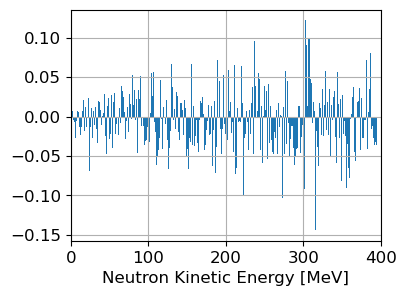

In [20]:
fig, ax = plt.subplots( figsize = (4, 3) )  

ax.bar(brn_bins[:-6], (outHist[0]-ref)/ref, width = np.diff(brn_bins[:-5]), align = "edge")
ax.set_xlabel( 'Neutron Kinetic Energy [MeV]', fontsize = 12 )
ax.tick_params(axis = 'x', labelsize = 12)
ax.tick_params(axis = 'y', labelsize = 12)
ax.set_xlim( [0, 400])
# ax.semilogy()
ax.grid(':')

## Generate the location and time: xyzt

In [21]:
rng = np.random.default_rng()
# location and time in [cm, ns]
# currently only support one cosmic ray in each event
xlim = 50.
yloc = -54.
zlim = 60.
xyzt = np.array([ [ x, y, z, t ] 
                      for x, y, z, t in zip(rng.uniform(-xlim, xlim, nSamples), 
                                            np.full(nSamples, yloc),
                                            rng.uniform(-zlim, zlim, nSamples),
                                            np.full(nSamples, 0.)) ])
xyzt

array([[-49.45416828, -54.        , -13.32111892,   0.        ],
       [ 36.51436146, -54.        ,  52.96890408,   0.        ],
       [-32.12352475, -54.        ,  44.04059228,   0.        ],
       ...,
       [-47.46221875, -54.        ,   6.68158041,   0.        ],
       [ 24.67382187, -54.        , -41.88315228,   0.        ],
       [-30.26182711, -54.        ,  18.58664554,   0.        ]])

(-1.0, 1.0)

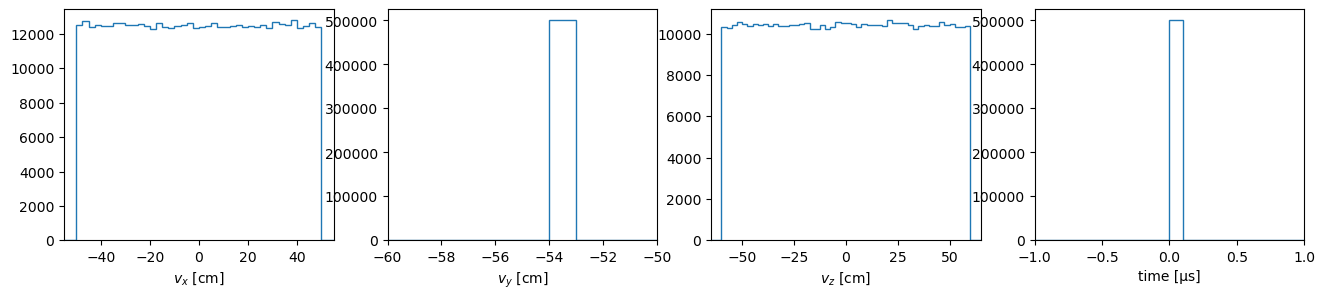

In [22]:
fig, ax = plt.subplots(1, 4, figsize = (16, 3) )

ax[0].hist(xyzt[:,0], bins = np.linspace(-55, 55, 45), histtype = 'step')
ax[0].set_xlabel(r'$v_x$ [cm]')
ax[0].set_xlim( [-55, 55] )

ax[1].hist(xyzt[:,1], bins = np.linspace(-60, -50, 11), histtype = 'step')
ax[1].set_xlabel(r'$v_y$ [cm]')
ax[1].set_xlim( [-60, -50] )

ax[2].hist(xyzt[:,2], bins = np.linspace(-65, 65, 53), histtype = 'step')
ax[2].set_xlabel(r'$v_z$ [cm]')
ax[2].set_xlim( [-65, 65] )

ax[3].hist(xyzt[:,3]/1000, bins = np.linspace( -1, 1, 21), histtype = 'step')
ax[3].set_xlabel('time [µs]')
ax[3].set_xlim( [-1, 1])

## Fill the output HEPEVT file

The output format is compatible with the HEPEVT reader of edep-sim: https://github.com/ClarkMcGrew/edep-sim/blob/master/src/kinem/EDepSimHEPEVTKinematicsGenerator.cc

In [23]:
import os
outdir = '/Users/yuntse/data/coherent/SNeNDSens/gen/BRN'

if os.path.exists(outdir):
    raise FileExistsError(f"Directory '{outdir}' already exists!")
else:
    os.makedirs(outdir)

In [24]:
nPdg = 2112
# unit: GeV
nMass = 0.9395654205
vtxID = 0
nParticlePerVtx = 1

In [25]:
nEventPerFile = 10000
nFiles = int(nSamples/nEventPerFile)
nFiles

50

In [26]:
for iFile in range(nFiles):
    outFile = f'{outdir}/BRN_{iFile:04d}.hepevt'

    with open( outFile, 'w') as f:
        for iEvtPerFile in range(nEventPerFile):
            iEvt = iFile*nEventPerFile + iEvtPerFile

            f.write( f'{iEvt} {vtxID} {nParticlePerVtx}\n')
    
            # ISTHEP IDHEP JMOHEP1 JMOHEP2 JDAHEP1 JDAHEP2 PHEP1 PHEP2 PHEP3 PHEP4 PHEP5 VHEP1 VHEP2 VHEP3 VHEP4
            # final-state particle
            ISTHEP = 1
            IDHEP = nPdg
            # The JMOHEP1, JMOHEP2, JDAHEP1, and JDAHEP2 entries record the indices (between 1 and NHEP, inclusive) 
            # of particles in the event record that correspond to the first mother, second mother, first daughter, 
            # and last daughter of the current particle, respectively. 
            JMOHEP1 = 0
            JMOHEP2 = 0
            JDAHEP1 = 0
            JDAHEP2 = 0

            # Calculate the 4-momentum
            E = voutSamples[iEvt]+nMass
            p = np.sqrt( E**2 - nMass**2 )
            px = 0.
            py = p
            pz = 0.

            # Fill momentum
            
            PHEP1 = px
            PHEP2 = py
            PHEP3 = pz
            PHEP4 = E
            PHEP5 = nMass
            VHEP1 = xyzt[iEvt][0]
            VHEP2 = xyzt[iEvt][1]
            VHEP3 = xyzt[iEvt][2]
            VHEP4 = xyzt[iEvt][3]
            f.write( f'{ISTHEP} {IDHEP} {JMOHEP1} {JMOHEP2} {JDAHEP1} {JDAHEP2} {PHEP1} {PHEP2} {PHEP3} {PHEP4} {PHEP5} {VHEP1} {VHEP2} {VHEP3} {VHEP4}\n')
            